# Report for 2D Project Physical World and Digital World

Cohort: F03

Team No.: 3

Members:
* Timothy Liu Kaihui (1002653)
* See Yi Jie (1002696)
* Natalie Tsang Yan Ting (1003087)
* Lu Jiangyi (1002950)
* Xiao Yiming (1002256)


# Introduction

We want to be able to predict the actual temperature of the water bath without waiting for the temperature sensor to reach thermal equilibrium with the water bath.

To do so, we use a linear model to correlate the temperature gradient at 11 seconds to the temperature difference between the water bath and the probe reading.


# Description of Data from Experiment

## Data Collection

We collect the temperature data of the water bath using provided the temperature probe.

The water bath is a plastic 2-litre container, which is filled up to a consistent volume each time.

The temperature measurements were all taken in class to minimise the variations in room temperature, and hence heat loss to surroundings.

We use an Arduino microcontroller to make the temperature probe accessible over a USB connected to either:

* the Raspberry Pi (for the demonstration)
* our laptops (data collection, training and testing)

The data is read over a serial connection using `pyserial` and saved into a `.csv` file.

We collected a total of 15 records of the experiment over a range of temperatures. We then reserved 3 records (20%) for testing.

## Data Preparation

**1. Find our experiment records**

In [1]:
!rm data/.DS_Store
from os import listdir
from os.path import isfile, join
data_raw = [f for f in listdir("data") if isfile(join("data", f))]
print(len(data_raw), "files:", str(data_raw))

rm: data/.DS_Store: No such file or directory
12 files: ['46.8.csv', '21.8.csv', '18.3.csv', '40.7.csv', '27.3.csv', '46.7.csv', '53.8.csv', '13.9.csv', '58.6.csv', '22.1.csv', '24.4.csv', '39.1.csv']


**2. Load records into a `data` dictionary**

In [2]:
import csv
import numpy as np
data = {}
for experiment in data_raw:
    t, temp = [], []
    with open("data/"+experiment) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            t.append(int(row[0])/1e3)
            temp.append(float(row[1]))
        data[experiment[:-4]] = (np.array(t[:200]), np.array(temp[:200])) # truncate the useless back part of the data

## Data Format

By plotting all our experimental data (except for the reserved test data), we can observe a temperature curve consistent with our expectations.

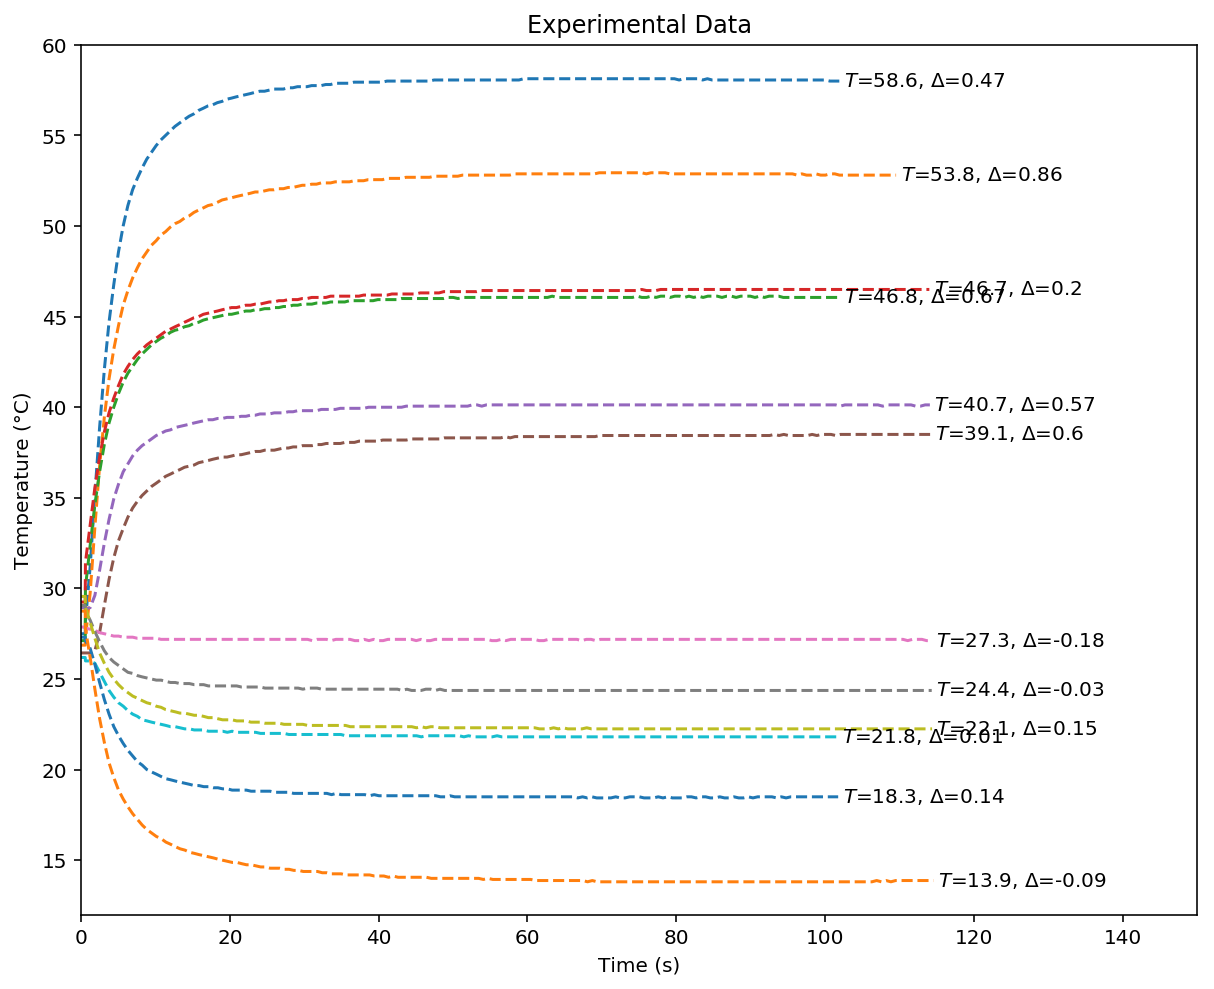

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.figure(1, figsize=(10, 8))
plt.title("Experimental Data")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.xticks(np.arange(0, 160, step=20))
plt.xlim(0,150)
plt.ylim(12,59)
plt.yticks(np.arange(15, 61, step=5))

ordered_experiments = list(data.keys())
ordered_experiments.sort()
for experiment in ordered_experiments[::-1]:
    t, temp = data[experiment]
    plt.plot(t, temp, '--', label=r"$T_i$="+experiment)
    if float(experiment) < 28:
        label = round(temp.min() - float(experiment), 2)
    else:
        label = round(float(experiment) - temp.max(), 2)
    plt.text(t[-1]+0.6,temp[-1]-0.3, r"$T$="+experiment+r", $\Delta$="+str(label))
plt.show()

# Training Model

We postulate that we can correlate:

* the average rate of temperature change in a certain time segment `[t1, t2]`, where `ΔT = t2 - t1`
* difference between temperature of the sensor and the actual temperature of the water at time `t[K] = t1 + ΔT/2 = t2 - ΔT/2`, where `t[K]` is the `K-th` data point in the time-series recorded for each experiment. 

We will then form a linear regression model using the `scikit-learn` module `LinearRegression` and tune the parameter `K` to find the best temperature range that gives us the lowest mean squared error (MSE).

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

We will first perform a parameter search for the ideal `K`

In [5]:
DEBUG = False # True to print results
K_list = range(25,100) # parameter search range

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


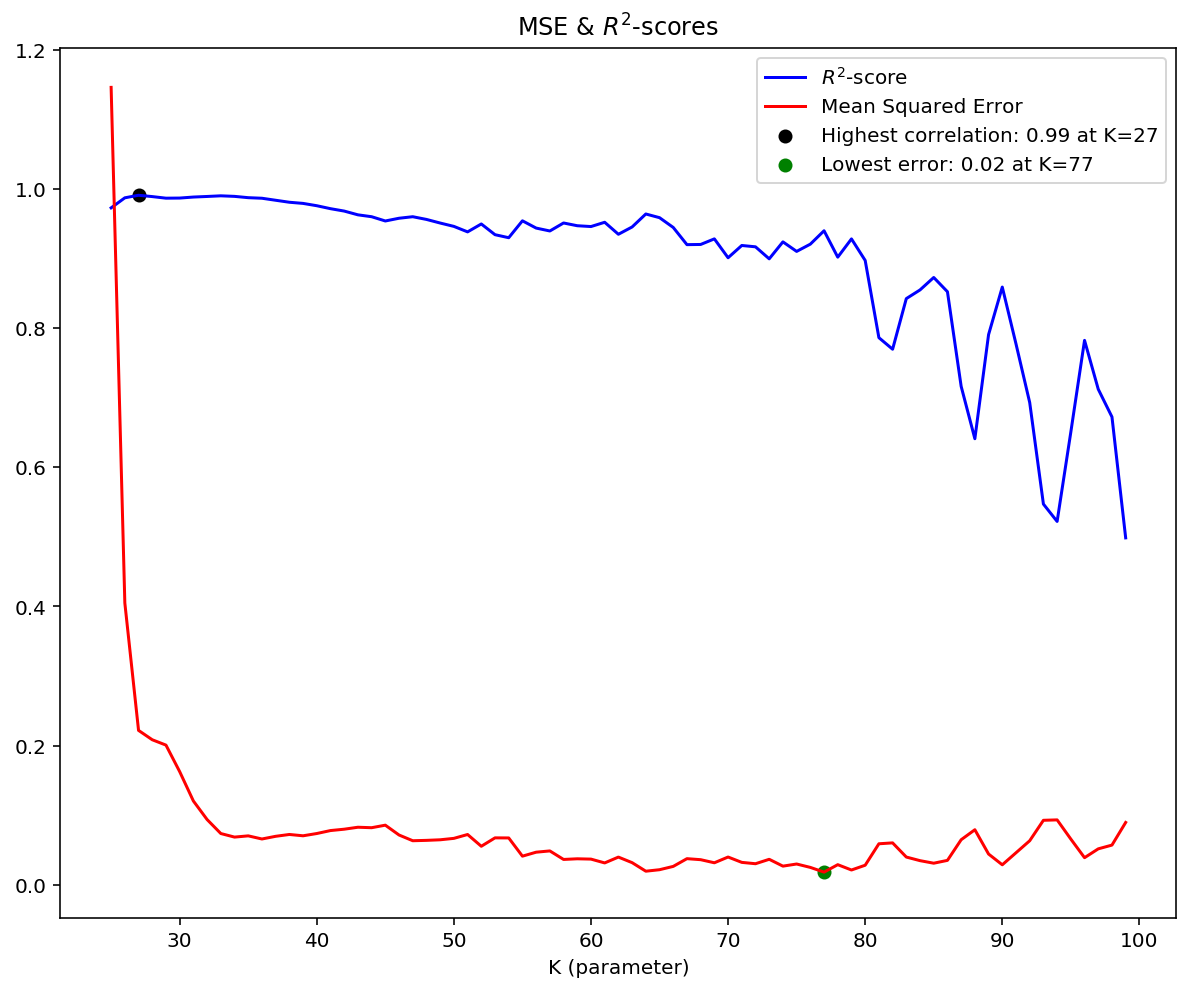

Lowest MSE occurs at 36.751 seconds, K = 77


In [6]:
K_mse, K_r2 = [], [] # results list

for K in K_list: # parameter search
    t_grads, t_diff = [], []
    for experiment in data.keys():
        t, temp = data[experiment]
        t_diff.append(float(experiment)-temp[K])
        t_grad = [(temp[x+2] - temp[x])/(t[x+2]-t[x]) for x in range(K-5,K+5)]
        t_grad_avg = sum(t_grad)/len(t_grad) # average gradient between t[K-5] and t[K+5]
        t_grads.append(t_grad_avg)
    targets, temps = np.array(t_diff).reshape(-1, 1), np.array(t_grads).reshape(-1, 1)
    regr = LinearRegression()
    regr.fit(temps, targets)
    t_pred = regr.predict(temps)
    
    mse, r2 = mean_squared_error(targets, t_pred), r2_score(targets, t_pred)

    K_mse.append(mse)
    K_r2.append(r2)
    
    if DEBUG == True:
        print("K =", K, end=": ")
        print("MSE: %.3f" % mse, end=", ")
        print('R2: %.3f' % r2) # 1 is perfect prediction
        
# plot the results
K_ex = K_list[K_mse.index(min(K_mse))], K_list[K_r2.index(max(K_r2))]
plt.figure(2, figsize=(10, 8))
plt.plot(K_list, K_r2, color="b", label=r"$R^{2}$-score")
plt.scatter(K_ex[1], max(K_r2), color="k", label="Highest correlation: "+str(round(max(K_r2),2))+" at K="+str(K_ex[1]))
plt.plot(K_list, K_mse, color="r", label="Mean Squared Error")
plt.scatter(K_ex[0], min(K_mse), color="g", label="Lowest error: "+str(round(min(K_mse),2))+" at K="+str(K_ex[0]))
plt.title(r"MSE & $R^{2}$-scores")
plt.xlabel("K (parameter)")
plt.legend()
plt.show()
print("Lowest MSE occurs at", t[K_ex[0]], "seconds, K =", K_ex[0])

Based on our parameter search, we will use ideally `K = 77` as our parameter as it gives the lowest mean squared error (MSE).

However, because we want to perform the prediction within 24 seconds, we have to choose a smaller `K` from the graph that still gives a low MSE.

A suitable local minimum can be found at `K = 36`.

In [7]:
K = 36
print("Chosen: K =", K, "corresponding to", t[K], "seconds")

Chosen: K = 36 corresponding to 10.747 seconds


Now, we can fit the model.

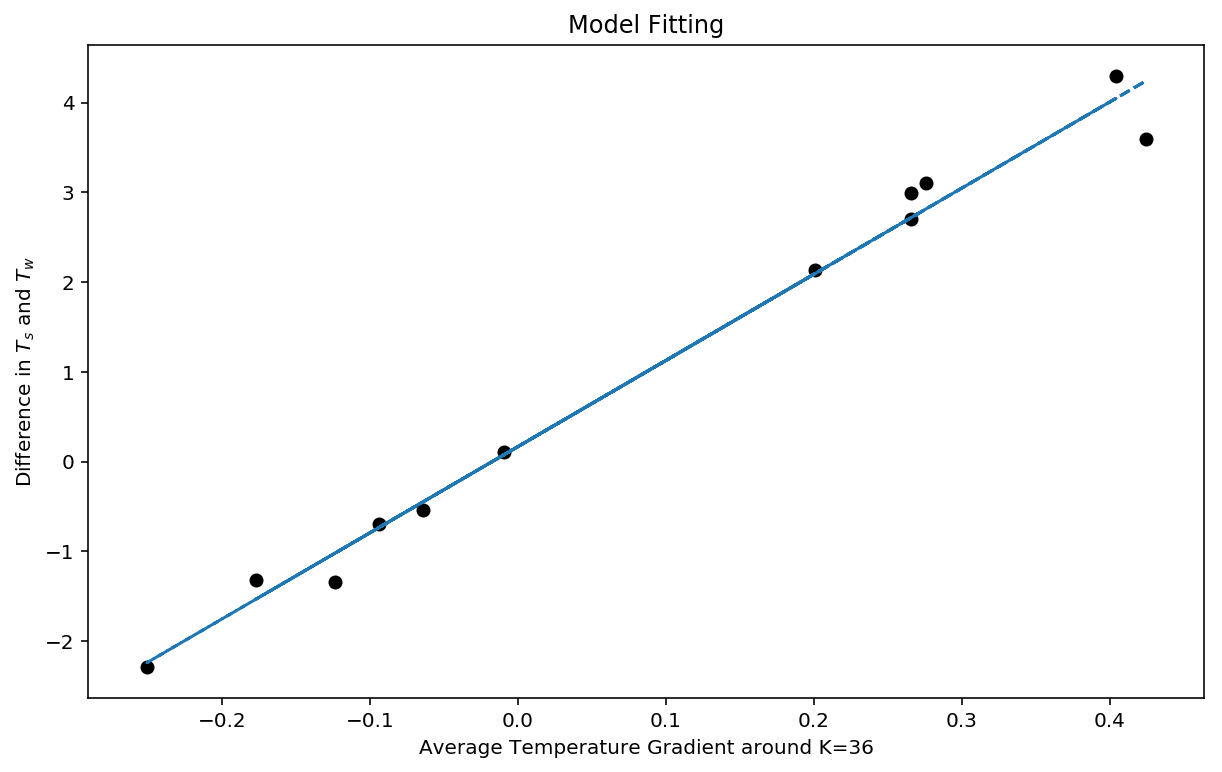

Equation: diff = 9.607006333328078 * delta + 0.1666478678934823
Mean squared error: 0.066, Variance score: 0.986


In [8]:
t_grads, t_diff = [], []

for experiment in data.keys():
        t, temp = data[experiment]
        t_diff.append(float(experiment)-temp[K])
        t_grad = [(temp[x+2] - temp[x])/(t[x+2]-t[x]) for x in range(K-5,K+5)]
        t_grad_avg = sum(t_grad)/len(t_grad) # average gradient between t[K-5] and t[K+5]
        t_grads.append(t_grad_avg)

targets, temps = np.array(t_diff).reshape(-1, 1), np.array(t_grads).reshape(-1, 1)
regr = LinearRegression()
regr.fit(temps, targets)
t_pred = regr.predict(temps)

plt.figure(3, figsize=(10, 6))
plt.scatter(temps, targets, color="k")
plt.plot(temps, t_pred, "--")
plt.title("Model Fitting")
plt.xlabel("Average Temperature Gradient around K="+str(K))
plt.ylabel(r"Difference in $T_s$ and $T_w$")
plt.show()

print("Equation: diff =", regr.coef_[0][0], "* delta +", regr.predict([[0]])[0][0])
print("Mean squared error: %.3f" % mean_squared_error(targets, t_pred), end=", ")
print('Variance score: %.3f' % r2_score(targets, t_pred)) # 1 is perfect prediction

# Verification and Accuracy

**1. Verify that the model did indeed fit onto our original training data.**

In [9]:
print("Errors at specific experiments:")
for n, temp in enumerate(temps):
    t_pred = regr.predict([temp])
    delta = (t_pred-t_diff[n])[0][0]
    print(abs(round(delta,2)), end=", ")

Errors at specific experiments:
0.27, 0.03, 0.21, 0.04, 0.03, 0.02, 0.25, 0.05, 0.64, 0.32, 0.09, 0.28, 

**2. Load our unseen test data**

In [10]:
!rm test/.DS_Store
test_raw = [f for f in listdir("test") if isfile(join("test", f))]
print(len(test_raw), "test files:", str(test_raw))
test = {}
for experiment in test_raw:
    t, temp = [], []
    with open("test/"+experiment) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            t.append(int(row[0])/1e3)
            temp.append(float(row[1]))
        test[experiment[:-4]] = (np.array(t[:200]), np.array(temp[:200]))
print("Test data:", list(test.keys()))

rm: test/.DS_Store: No such file or directory
3 test files: ['56.6.csv', '33.8.csv', '19.7.csv']
Test data: ['56.6', '33.8', '19.7']


**3. Make predictions using test data**

In [11]:
def predict_final(model, K, temp):
    t_grad = [(temp[x+2] - temp[x])/(t[x+2]-t[x]) for x in range(K-5,K+5)]
    t_grad_avg = sum(t_grad)/len(t_grad)
    return model.predict([[t_grad_avg]]) + temp[K]

K = 64 # parameter
for experiment in test.keys():
    t, temp = test[experiment]
    pred = round(predict_final(regr, K, temp)[0][0], 3)
    print("   Actual:", experiment, "\nPredicted:", pred)
    print("    Error:", round(abs(float(experiment)-pred),3), end="\n\n")

   Actual: 56.6 
Predicted: 56.38
    Error: 0.22

   Actual: 33.8 
Predicted: 33.903
    Error: 0.103

   Actual: 19.7 
Predicted: 20.365
    Error: 0.665



**4. Save the model**

In [12]:
import pickle
with open('model.pickle', 'wb') as handle:
    pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Testing Using Instructor's Data

Instruction:

* Store your trained model into a pickle object which can be loaded. 
* Read an excel file with the following format:
```
time (s)	reading
0.00	    25.812
0.90	    28.562
1.79	    31.875
2.68	    35.062
3.55	    37.937
4.43	    40.687
5.30	    43.25
```
where the first column indicates the time in seconds and the second column indicates the sensor reading in Celsius. 
* The number of rows in the instructors' data can be of any number. If your code has a minimum number of rows, your code must be able to handle and exit safely when the data provided is less than the required minimum.
* Write a code to prepare the data for prediction.
* Write a code to predict the final temperature.



In [13]:
# write a code to load your trained model from a pickle object
import pickle
filename = 'model.pickle' # enter your pickle file name containing the model
with open(filename,'rb') as f:
    model = pickle.load(f)

In [14]:
# write a code to read an excel file
import pandas as pd
num_test = 1
filename = 'temp_' 
filekey = ["51"] # instructors will key in this
dataframe = {} # this is to store the data for different temperature, the keys are in filekey
for idx in range(num_test):
    dataframe[filekey[idx]] = pd.read_excel(filename+filekey[idx]+'.xlsx')

In [15]:
# write a code to prepare the data for predicting
def find_nearest_index(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def preprocess(df):
    t_target = 10.7 # original t[K] from own experiments
    time, temp = list(df["time (s)"][:100]), list(df["reading"][:100])
    K = find_nearest_index(np.array(time), 18.4)
    t_grad = [(temp[x+2] - temp[x])/(t[x+2]-t[x]) for x in range(K-2,K+2)] # 2 instead of 5 due to difference in measurement time-intervals
    t_grad_avg = sum(t_grad)/len(t_grad)
    return t_grad_avg, temp[K]

data_test = {}
for key in filekey:
    data_test[key]=preprocess(dataframe[key])
    print(data_test)

{'51': (0.7839042780472516, 40.75)}


In [16]:
# write a code to predict the final temperature
# store the predicted temperature in a variable called "predicted"
# predicted is a dictionary where the keys are listed in filekey

predicted = {}
for key in filekey:
    predicted[key]=model.predict(data_test[key][0])+data_test[key][1]

In [17]:
predicted

{'51': array([[48.44762123]])}

In [18]:
# checking accuracy

# first instructor will load the actual temp from a pickle object
import pickle
error_d = {}
accuracy_percent_d = {}

for test in range(num_test):
    filename = 'data_'+filekey[test]+'.pickle'
    with open(filename,'rb') as f:
        final_temp, worst_temp = pickle.load(f)

    # then calculate the error
    error_final = abs(final_temp-predicted[filekey[test]])
    accuracy_final_percent = 100-error_final/final_temp*100
    error_worst = abs(worst_temp-predicted[filekey[test]])
    accuracy_worst_percent = 100-error_worst/worst_temp*100
    
    error_d[filekey[test]] = (error_final, error_worst)
    accuracy_percent_d[filekey[test]] = (accuracy_final_percent, accuracy_worst_percent)

    # displaying the error
    print('===================================')
    print('Testing: {}'.format(filekey[test]))
    print('Predicted Temp: {:.2f}'.format(predicted[filekey[test]]))
    print('Final Sensor Temp: {:.2f}, Alcohol Temp:{:.2f}'.format(final_temp, worst_temp))
    print('Error w.r.t Final Sensor Temp: {:.2f} deg, {:.2f}% accuracy'.format(error_final, accuracy_final_percent))
    print('Error w.r.t Alcohol Temp: {:.2f} deg, {:.2f}% accuracy'.format(error_worst, accuracy_worst_percent))
    
avg_final = sum([ final for final, worst in accuracy_percent_d.values()])/len(error_d.values())
avg_worst = sum([ worst for final, worst in accuracy_percent_d.values()])/len(error_d.values())
print('==============================')
print('Average accuracy for final sensor temp: {:.2f}'.format(avg_final))
print('AVerage accuracy for alcohol temp: {:.2f}'.format(avg_worst))

FileNotFoundError: [Errno 2] No such file or directory: 'data_51.pickle'